In [1]:
require(cowplot)
require(data.table)
require(ggplot2)
require(ggpubr)
require(pbapply)
pboptions(type="timer")

Loading required package: cowplot


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************


Loading required package: data.table

Loading required package: ggplot2

Loading required package: ggpubr


Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend


Loading required package: pbapply



In [2]:
nthreads=10
x_breaks = c(0, .01, .02, .03, .05, .07, .1, .2, .3, .5, .7, 1, 2, 3, 5, 7, 10, 20, 30, 50)

# Read spot data

In [3]:
thresholds = c(seq(0, .1, by=.01), seq(.2, 1, by=.1), seq(2, 50))
dw__root = "../data/single_FoV_different_thresholds/data/dw/"
raw_root = "../data/single_FoV_different_thresholds/data/raw/"

In [4]:
dw__data = rbindlist(pblapply(thresholds, function(thr) {
    d = fread(file.path(dw__root, sprintf("new_decoded_human_cortex_threshold_%05.2f_with_QC_metrics_type_of_unassigned.csv.gz", thr)))
    d$thr = thr
    d$image_type = "dw"
    return(d)
}, cl=nthreads))

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=05s  


In [5]:
raw_data = rbindlist(pblapply(thresholds, function(thr) {
    d = fread(file.path(raw_root, sprintf("new_decoded_human_cortex_before_deconvolution_threshold_%05.2f_with_QC_metrics_type_of_unassigned.csv.gz", thr)))
    d$thr = thr
    d$image_type = "raw"
    return(d)
}, cl=nthreads))

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=04s  


In [6]:
ddata = rbindlist(list(dw__data, raw_data))
ddata[, V1 := NULL]
ddata[, target_assigned := "unassigned"]
ddata['nan' != target, target_assigned := "assigned"]

In [7]:
colnames(ddata)

[1] "intensity"         "z"                 "y"                
 [4] "x"                 "radius"            "spot_id"          
 [7] "z_min"             "z_max"             "y_min"            
[10] "y_max"             "x_min"             "x_max"            
[13] "features"          "xc"                "yc"               
[16] "zc"                "target"            "distance"         
[19] "passes_thresholds" "FOV"               "QC_score"         
[22] "thr"               "image_type"        "target_assigned"

In [8]:
gene_counts = dcast(ddata["assigned" == target_assigned, .N, by=c("image_type", "target", "thr")],
                    target+thr~image_type, value.var="N")[order(dw, decreasing=T)]
colnames(gene_counts)

[1] "target" "thr"    "dw"     "raw"

# Read strip data

In [9]:
cell_data = rbindlist(pblapply(c("dw", "raw"), function(image_type) {
    d = fread(file.path("../data/strip_of_tissue", image_type, "MP_snRNAseq_filt_subclass.csv"))
    d$image_type = image_type
    return(d)
}, cl=nthreads))
cell_data[, V1 := NULL]
cell_data[, annotated := "unannotated"]
cell_data["Zero" != ClassName, annotated := "annotated"]
colnames(cell_data)

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


[1] "Cell_Num"   "X"          "Y"          "ClassName"  "Prob"      
[6] "image_type" "annotated"

# Panel X4A
Median quality score of assigned dots.

In [10]:
qc_data = ddata["assigned" == target_assigned, .(
    QC_min=min(QC_score), QC_mean=mean(QC_score), QC_median=median(QC_score), QC_max=max(QC_score)
), by=c("image_type", "thr")]
qc_data["dw" == image_type, image_type := "DW"]

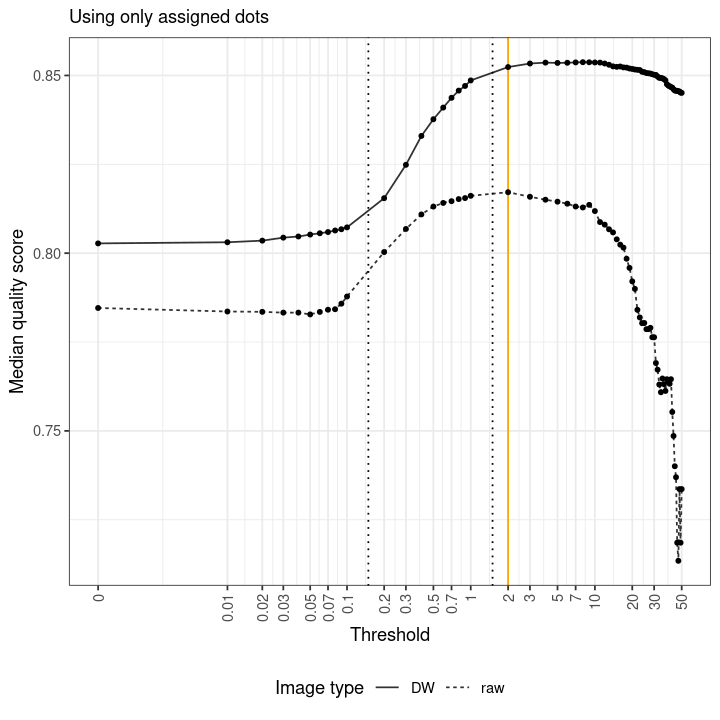

In [11]:
options(repr.plot.width=6, repr.plot.height=6)
p = ggplot(qc_data, aes(x=thr+.001, y=QC_median, linetype=image_type)) +
    geom_vline(xintercept=c(2), color="orange", linetype="solid") +
    geom_line(color="#323232") + geom_point(size=1) +
    theme_bw() + theme(axis.text.x=element_text(angle=90, hjust=1, vjust=.5), legend.position="bottom") +
    labs(x="Threshold", y="Median quality score", linetype="Image type", subtitle="Using only assigned dots") +
    geom_vline(xintercept=c(.15, 1.5), color="black", linetype="dotted") +
    scale_x_log10(breaks=x_breaks+.001, labels=x_breaks)
print(p)

In [12]:
ggsave(plot=p, file="panels/supp_fig_x4a.png", width=4, height=4)
saveRDS(p, "panels_rds/supp_fig_x4a.rds")